# PuLP でブレンド問題 (Blending Problem) を解く  

PuLP は Python で線形計画 (Linear Programing) 問題をモデル化し、ソルバーで解くためのツールです。  

- [coin-or/pulp: A python Linear Programming API](https://github.com/coin-or/pulp)  
- [Optimization with PuLP](https://coin-or.github.io/pulp/)  
- [pulp: Pulp classes](https://coin-or.github.io/pulp/technical/pulp.html)  

Anaconda Cloud ではパッケージは公開されていませんので、`pip install pulp` でインストールしてください。  

## 問題_1  

ある飲料品メーカでは「ブラックコーヒー」と「ミルクコーヒー」の 2 種類の製品を生産し販売しています。  

ブラックコーヒーは 1 kg あたり 50 円、ミルクコーヒーは 1 kg あたり 40 円の利益となります。それぞれの製品を 1 kg 生産するために必要な原料の重量および 1 カ月間の制限量は以下の通りです。  

|原料|ブラックコーヒー必要量<br>\[kg\]|ミルクコーヒー必要量<br>\[kg\]|使用制限量<br>\[t\]|
|:---:|:---:|:---:|:---:|
|キリマンジャロエキス|0.15|0.05|50|
|コロンビアエキス|0.05|0.10|40|

また、工場の 1 カ月間の生産能力は両製品合わせて最大 500 t です。  

生産したものはすべて売れて予定通りの利益を得られるとしたとき、2 つの製品をどれくらいずつ生産すれば一番多く利益を上げることができるでしょうか？  

### 定式化  

#### 決定変数  

$$\begin{split}bcp &=  \text{ black coffee production }\\
mcp &= \text{ milk coffee production }\end{split}$$

#### 目的関数  

$$\textbf{Maximize } 50 bcp + 40 mcp$$

#### 制約条件  

$$\begin{split} 0.15 bcp + 0.05 mcp &\leq 50000\\  0.05 bcp + 0.10 mcp &\leq 40000\\ bcp + mcp &\leq 500000 \\ \end{split}$$

### PuLP で解く  

In [1]:
# 必要なモジュールのインポート
import pulp
from pulp import LpProblem, LpMinimize, LpMaximize, LpVariable, LpInteger, LpContinuous, lpSum
import numpy as np
import matplotlib.pyplot as plt

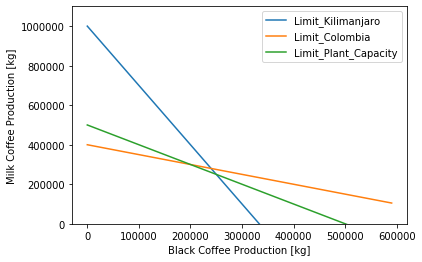

In [2]:
# ひとまず条件を可視化してみる
x_0 = np.arange(0, 600000, 10000)

y_lk_0 = -3.0*x_0 + 1000000
y_lc_0 = -0.5*x_0 + 400000
y_lp_0 = -x_0 + 500000

plt.plot(x_0, y_lk_0, label="Limit_Kilimanjaro")
plt.plot(x_0, y_lc_0, label="Limit_Colombia")
plt.plot(x_0, y_lp_0, label="Limit_Plant_Capacity")
plt.legend()

plt.xlabel("Black Coffee Production [kg]"); plt.ylabel("Milk Coffee Production [kg]")
plt.ylim(0, 1100000)

plt.show()

`LpProblem` クラスを用いえてモデルを作成します。  
1 番目の引数 `name=` はそのモデルを表す任意の名前。2 番目の引数 `sense=` はモデルの対象 (デフォルトは `LpMinimize` で目的関数の最小化/ `LpMaximize` で最大化) です。  

In [3]:
# モデルの作成 (最大化)
seisankeikaku_0 = LpProblem(name="生産計画", sense=LpMaximize)

`LpVariable` クラスを用いて 2 つの決定変数を作成します。  
1 番目の引数 `name=` はその変数を表す任意の名前。2 番目の引数 `lowBound=` は変数の下限 (デフォルトは `None` で負の無限大)。3 番目の引数 `upBound=` は変数の上限 (デフォルトは `None` で正の無限大)。4 番目の引数 `cat=` は変数のカテゴリ (デフォルトは `LpContinuous` で連続値/今回は整数の離散値である `LpInteger` を使う) です。  

In [4]:
# 決定変数の作成
bcp = LpVariable(name="ブラックコーヒー", lowBound=0, upBound=None, cat=LpInteger)
mcp = LpVariable("ミルクコーヒー", 0, None, LpInteger)

まずはじめに目的関数をモデルに加え、その後に制約条件を加えます。  
`LpVariable` クラスに対して `+=` 演算子を使って、`LpVariable += 目的関数 or 制約条件, 式の説明 (省略可)` で追加していきます。  

In [5]:
# 目的関数をモデルに追加
seisankeikaku_0 += 50*bcp + 60*mcp, "販売利益"

In [6]:
# 制約条件をモデルに追加
seisankeikaku_0 += 0.15*bcp + 0.05*mcp <= 50000, "キリマンジャロエキス制限"
seisankeikaku_0 += 0.05*bcp + 0.10*mcp <= 40000, "コロンビアエキス制限"
seisankeikaku_0 += bcp + mcp <= 500000, "生産装置制限"

In [7]:
# モデルを確認
seisankeikaku_0

生産計画:
MAXIMIZE
50*ブラックコーヒー + 60*ミルクコーヒー + 0
SUBJECT TO
キリマンジャロエキス制限: 0.15 ブラックコーヒー + 0.05 ミルクコーヒー <= 50000

コロンビアエキス制限: 0.05 ブラックコーヒー + 0.1 ミルクコーヒー <= 40000

生産装置制限: ブラックコーヒー + ミルクコーヒー <= 500000

VARIABLES
0 <= ブラックコーヒー Integer
0 <= ミルクコーヒー Integer

In [8]:
# モデルをソルバーで解く
seisankeikaku_0.solve()

1

`LpProblem.solve()` が返す整数値の意味は以下の通りです。

|整数値|文字列|説明|
|:---:|:---|:----|
|1|Optimal|許容される範囲内での厳密解が得られた|
|-1|Infeasible|実行可能領域が空|
|-2|Unbounded|非有界|
|0|Not Solved|時間制限で停止した場合など|
|-3|Undefined|PuLP で判断できない問題|


In [9]:
# ステータスを文字列として表示
print("Status:", pulp.LpStatus[seisankeikaku_0.status])

Status: Optimal


### 結果の分析  

`pulp.value()` は PuLP の変数や式を評価した値を返します。  
モデルを解いたあとの決定変数、目的関数、制約条件を確認していきます。  

`LpProblem.variables()` は `LpVariable` (決定変数) のリストを返します。  

In [10]:
seisankeikaku_0.variables()

[ブラックコーヒー, ミルクコーヒー]

In [11]:
type(seisankeikaku_0.variables()[0])

pulp.pulp.LpVariable

`LpVariable.name` には決定変数の名前が格納されています。  
なお、決定変数の値は `LpVariable.verValue` でも確認できます。  

In [12]:
# 生産量 (解) と利益の表示
for v in seisankeikaku_0.variables():
    print(v.name, ":", pulp.value(v), "kg")

ブラックコーヒー : 200000.0 kg
ミルクコーヒー : 300000.0 kg


`LpProblem.objective` には目的関数 (クラス: `LpAffineExpression`) が格納されています。  

In [13]:
seisankeikaku_0.objective

50*ブラックコーヒー + 60*ミルクコーヒー + 0

In [14]:
type(seisankeikaku_0.objective)

pulp.pulp.LpAffineExpression

In [15]:
# 最大化された目的関数の値を表示
print("販売利益:", pulp.value(seisankeikaku_0.objective), "円")

販売利益: 28000000.0 円


`LpProblem.constrains` には、制約条件 (クラス: `LpConstraint`) が順序付き辞書 (クラス: `collections.OrderedDict`) 形式で格納されています。  

In [16]:
seisankeikaku_0.constraints

OrderedDict([('キリマンジャロエキス制限', 0.15*ブラックコーヒー + 0.05*ミルクコーヒー + -50000.0 <= 0),
             ('コロンビアエキス制限', 0.05*ブラックコーヒー + 0.1*ミルクコーヒー + -40000.0 <= 0),
             ('生産装置制限', 1*ブラックコーヒー + 1*ミルクコーヒー + -500000 <= 0)])

※`LpConstraint` では制約条件をモデルに追加した際の式の右辺の定数が左辺に移項されています。  

In [17]:
type(seisankeikaku_0.constraints["キリマンジャロエキス制限"])

pulp.pulp.LpConstraint

In [18]:
# 制約条件式左辺の値を表示 
for i in seisankeikaku_0.constraints.items():
    print(i[0], ":", pulp.value(i[1]), "kg")

キリマンジャロエキス制限 : -5000.0 kg
コロンビアエキス制限 : 0.0 kg
生産装置制限 : 0.0 kg


キリマンジャロエキスは、使用制限に対してまだ 5 t の余裕があったようです。  

### 制約条件を変えてみる  

コロンビアエキスの使用制限を緩和し、45 t 使用できるようにしたと仮定して再度検討してみます。  

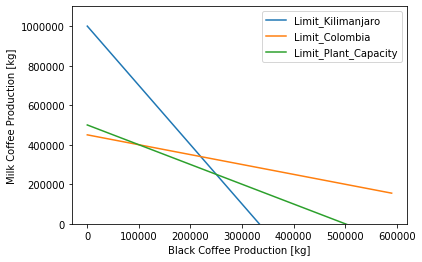

In [19]:
# 再度、条件を可視化してみる
x_1 = np.arange(0, 600000, 10000)

y_lk_1 = -3.0*x_1 + 1000000
y_lc_1 = -0.5*x_1 + 450000
y_lp_1 = -x_1 + 500000

plt.plot(x_1, y_lk_1, label="Limit_Kilimanjaro")
plt.plot(x_1, y_lc_1, label="Limit_Colombia")
plt.plot(x_1, y_lp_1, label="Limit_Plant_Capacity")
plt.legend()

plt.xlabel("Black Coffee Production [kg]"); plt.ylabel("Milk Coffee Production [kg]")
plt.ylim(0, 1100000)

plt.show()

In [20]:
# 元のモデルをコピー
seisankeikaku_1 = seisankeikaku_0.copy()

In [21]:
# モデルの名前を変更
seisankeikaku_1.name = "生産計画_改"
seisankeikaku_1

生産計画_改:
MAXIMIZE
50*ブラックコーヒー + 60*ミルクコーヒー + 0
SUBJECT TO
キリマンジャロエキス制限: 0.15 ブラックコーヒー + 0.05 ミルクコーヒー <= 50000

コロンビアエキス制限: 0.05 ブラックコーヒー + 0.1 ミルクコーヒー <= 40000

生産装置制限: ブラックコーヒー + ミルクコーヒー <= 500000

VARIABLES
0 <= ブラックコーヒー Integer
0 <= ミルクコーヒー Integer

In [22]:
# 制約条件式の右辺 (Right Hand Side) を変更
seisankeikaku_1.constraints["コロンビアエキス制限"].changeRHS(45000)

In [23]:
# 変更の確認
seisankeikaku_1

生産計画_改:
MAXIMIZE
50*ブラックコーヒー + 60*ミルクコーヒー + 0
SUBJECT TO
キリマンジャロエキス制限: 0.15 ブラックコーヒー + 0.05 ミルクコーヒー <= 50000

コロンビアエキス制限: 0.05 ブラックコーヒー + 0.1 ミルクコーヒー <= 45000

生産装置制限: ブラックコーヒー + ミルクコーヒー <= 500000

VARIABLES
0 <= ブラックコーヒー Integer
0 <= ミルクコーヒー Integer

In [24]:
# モデルを解く
seisankeikaku_1.solve()

1

In [25]:
# 結果の表示
for v in seisankeikaku_1.variables():
    print(v.name, ":", pulp.value(v), "kg")
print("-"*15)
print("販売利益:", pulp.value(seisankeikaku_1.objective), "円")
print("-"*15)
for i in seisankeikaku_1.constraints.items():
    print(i[0], ":", pulp.value(i[1]), "kg")

ブラックコーヒー : 100000.0 kg
ミルクコーヒー : 400000.0 kg
---------------
販売利益: 29000000.0 円
---------------
キリマンジャロエキス制限 : -15000.0 kg
コロンビアエキス制限 : 0.0 kg
生産装置制限 : 0.0 kg


## 問題 2  



あるペット用品メーカでドッグフードを製造しています。ドッグフードの原料のコストおよび栄養素の含有割合は以下の通りです。  

|原料|コスト<br>\[JPY/g\]|タンパク質<br>\[%\]|脂質<br>\[%\]|炭水化物<br>\[%\]|食物繊維<br>\[%\]|食塩<br>\[%\]|
|--- |---: |---: |---: |---: |---: |---: |
|鶏肉|0.30|10.0|8.0 |2.0 |0.1|0.2|
|牛肉|0.50|20.0|10.0|1.0 |0.5|0.5|
|羊肉|0.40|15.0|11.0|1.0 |0.3|0.7|
|米  |0.20|1.3 |0.2 |40.0|2.3|0.0|
|小麦|0.25|8.3 |1.5 |50.0|2.5|0.2|

この製品のラベルには、  

- タンパク質含有量: 15 % 以上  
- 脂質含有量: 8 % 以下  
- 炭水化物含有量: 8 % 以上  
- 食物繊維含有量: 1 % 以下
- 食塩含有量: 1 % 以下  

と記載されます。成分表示記載を満足したうえで 1 缶 (100 g) の原料コストを最小にする配合はどのようになるでしょうか？  

### 定式化  

#### 決定変数  

$$\begin{split}x_1 &= \text{amount of chicken meat in a can of dog food}\\
x_2 &= \text{amount of beef used in a can of dog food}\\
x_3 &= \text{amount of mutton used in a can of dog food}\\
x_4 &= \text{amount of rice used in a can of dog food}\\
x_5 &= \text{amount of wheat used in a can of dog food}\\
\end{split}$$

#### 目的関数  

$$\textbf{Minimize } 0.30 x_1 + 0.50 x_2 + 0.40 x_3 + 0.20 x_4 + 0.25 x_5$$

#### 制約条件  

$$
\begin{split}x_1 + x_2 + x_3 + x_4 + x_5 &= 100 \\
             0.100 x_1 +0.200 x_2 +0.150 x_3 +0.013 x_4 +0.025 x_5 &\ge 15.0 \\
             0.080 x_1 +0.100 x_2 +0.110 x_3 +0.002 x_4 +0.015 x_5 &\le 8.0 \\
             0.020 x_1 +0.010 x_2 +0.010 x_3 +0.400 x_4 +0.500 x_5 &\ge 8.0 \\
             0.001 x_1 +0.005 x_2 +0.003 x_3 +0.023 x_4 +0.025 x_5 &\le 1.0 \\
             0.002 x_1 +0.005 x_2 +0.007 x_3 +0.000 x_4 +0.002 x_5 &\le 1.4\end{split}$$

この問題は変数および制約条件の数が多いので、前の問題のように図で表すことも困難ですね💦  

ここでは辞書 (`dict`) を利用して決定変数、目的関数、制約条件を作成します。  

In [26]:
# 原料のリスト
ingredients = ["CHICKEN", "BEEF", "MUTTON", "RICE", "WHEAT"]

# 原料名とコストを対応付けた辞書
costs = {"CHICKEN": 0.300, 
         "BEEF":    0.500, 
         "MUTTON":  0.400, 
         "RICE":    0.200, 
         "WHEAT":   0.250, 
         }

# 原材料名とタンパク質含有量を対応付けた辞書
protein_percent = {"CHICKEN": 0.100,
                   "BEEF":    0.200, 
                   "MUTTON":  0.150, 
                   "RICE":    0.013, 
                   "WHEAT":   0.083, 
                   }

# 原材料名と脂質含有量を対応付けた辞書
fat_percent = {"CHICKEN": 0.080, 
               "BEEF":    0.100, 
               "MUTTON":  0.110, 
               "RICE":    0.002, 
               "WHEAT":   0.015, 
               }

# 原材料名と炭水化物含有量を対応付けた辞書
Carbohydrate_percent = {"CHICKEN": 0.020, 
                        "BEEF":    0.010, 
                        "MUTTON":  0.010, 
                        "RICE":    0.400, 
                        "WHEAT":   0.500, 
                        }

# 原材料名と食物繊維含有量を対応付けた辞書
fiber_percent = {"CHICKEN": 0.001, 
                 "BEEF":    0.005, 
                 "MUTTON":  0.003, 
                 "RICE":    0.023, 
                 "WHEAT":   0.025, 
                 }

# 原材料名と食塩含有量を対応付けた辞書
salt_percent = {"CHICKEN": 0.002, 
                "BEEF":    0.005, 
                "MUTTON":  0.007, 
                "RICE":    0.000, 
                "WHEAT":   0.002, 
                }

In [27]:
# モデルの作成 (最小化)
dogfood = LpProblem("ドッグフード配合", LpMinimize)

`LpVariable.dict()` メソッドを用いて `LpVariable` (決定変数) の辞書を作成します。  
1 番目の引数 `name=` は各変数名の前に付けられる接頭語 (間に `_` が自動で入る)。2 番目の引数 `indexes=` は決定変数名のリスト。3 番目の引数 `lowBound=` は変数の下限 (デフォルトは `None` で負の無限大)。3 番目の引数 `upBound=` は変数の上限 (デフォルトは `None` で正の無限大)。4 番目の引数 `cat=` は変数のカテゴリ (デフォルトは `LpContinuous` で連続値/今回は整数の離散値である `LpInteger` を使う) です。  

In [28]:
# 複数の決定変数を格納する辞書を作成
ingredient_vars = LpVariable.dicts(name="Ingr", indexs=ingredients, lowBound=0, upBound=None, cat=LpInteger)
print(ingredient_vars)
print(type(ingredient_vars))
print(type(ingredient_vars["CHICKEN"]))

{'CHICKEN': Ingr_CHICKEN, 'BEEF': Ingr_BEEF, 'MUTTON': Ingr_MUTTON, 'RICE': Ingr_RICE, 'WHEAT': Ingr_WHEAT}
<class 'dict'>
<class 'pulp.pulp.LpVariable'>


リスト内法表記と `lpSum()` 関数を使って目的関数と制約条件をモデルに追加します。  

In [29]:
# lpsum() 関数を使って目的関数をモデルに加える
# 右辺関数は 0.3*Ingr_CHICKEN + 0.5*Ingr_BEEF + 0.4*Ingr_MUTTON + 0.2*Ingr_RICE + 0.25*Ingr_WHEAT の意
dogfood += lpSum([costs[i]*ingredient_vars[i] for i in ingredients]), "Total Cost of Ingredients per can"

In [30]:
# 同様に制約条件をモデルに加える
dogfood += lpSum([ingredient_vars[i] for i in ingredients]) == 100, "原料合計"
dogfood += lpSum([protein_percent[i] * ingredient_vars[i] for i in ingredients]) >= 15.0, "タンパク質含有率"
dogfood += lpSum([fat_percent[i] * ingredient_vars[i] for i in ingredients]) <= 8.0, "脂質含有率"
dogfood += lpSum([Carbohydrate_percent[i] * ingredient_vars[i] for i in ingredients]) >= 8.0, "炭水化物含有率"
dogfood += lpSum([fiber_percent[i] * ingredient_vars[i] for i in ingredients]) <= 1.0, "食物繊維含有率"
dogfood += lpSum([salt_percent[i] * ingredient_vars[i] for i in ingredients]) <= 1.0, "食塩含有率"

In [31]:
# モデルの確認
print(dogfood)

ドッグフード配合:
MINIMIZE
0.5*Ingr_BEEF + 0.3*Ingr_CHICKEN + 0.4*Ingr_MUTTON + 0.2*Ingr_RICE + 0.25*Ingr_WHEAT + 0.0
SUBJECT TO
原料合計: Ingr_BEEF + Ingr_CHICKEN + Ingr_MUTTON + Ingr_RICE + Ingr_WHEAT = 100

タンパク質含有率: 0.2 Ingr_BEEF + 0.1 Ingr_CHICKEN + 0.15 Ingr_MUTTON
 + 0.013 Ingr_RICE + 0.083 Ingr_WHEAT >= 15

脂質含有率: 0.1 Ingr_BEEF + 0.08 Ingr_CHICKEN + 0.11 Ingr_MUTTON + 0.002 Ingr_RICE
 + 0.015 Ingr_WHEAT <= 8

炭水化物含有率: 0.01 Ingr_BEEF + 0.02 Ingr_CHICKEN + 0.01 Ingr_MUTTON + 0.4 Ingr_RICE
 + 0.5 Ingr_WHEAT >= 8

食物繊維含有率: 0.005 Ingr_BEEF + 0.001 Ingr_CHICKEN + 0.003 Ingr_MUTTON
 + 0.023 Ingr_RICE + 0.025 Ingr_WHEAT <= 1

食塩含有率: 0.005 Ingr_BEEF + 0.002 Ingr_CHICKEN + 0.007 Ingr_MUTTON
 + 0.002 Ingr_WHEAT <= 1

VARIABLES
0 <= Ingr_BEEF Integer
0 <= Ingr_CHICKEN Integer
0 <= Ingr_MUTTON Integer
0 <= Ingr_RICE Integer
0 <= Ingr_WHEAT Integer



In [32]:
dogfood.solve()

1

In [33]:
# 結果の表示
for v in dogfood.variables():
    print(v.name, ":", pulp.value(v), "g")
print("-"*15)
print("コスト:", pulp.value(dogfood.objective), "円")

Ingr_BEEF : 55.0 g
Ingr_CHICKEN : 17.0 g
Ingr_MUTTON : 0.0 g
Ingr_RICE : 0.0 g
Ingr_WHEAT : 28.0 g
---------------
コスト: 39.6 円


## 参考文献  

- [A Blending Problem — PuLP 2.0 documentation](https://coin-or.github.io/pulp/CaseStudies/a_blending_problem.html)  
- [問題解決のためのオペレーションズ・リサーチ入門｜日本評論社](https://www.nippyo.co.jp/shop/book/1404.html)  